# Part 6 - Predicting Review Classifications

## Tasks
For this part of the project, you will using machine learning and deep NLP to classify the reviews.
### Repo Prep


- Create a `"Models/"` folder in your project repository, with the following sub-folders: 
    - `"Models/ml/"`. You will save your sklearn model pipelines here for later use in deployment.
    - `"Models/nn/"`. You will save your tensorflow models here for later use in deployment.
- Add new subfolders to your "Data-NLP/"" folder.
    - Specifically, create:
        - `"Data-NLP/ml/"` folder. We will save your training and test data (X_train,y_train) for later use in deployment.
        - `"Data-NLP/nn/"` folder.  We will save your training and test Tensorflow datasets for later use in deployment.
     

    
- Create a new notebook for Part 6 - Review Classification for this part of the project. 

### Load the Data

- Load the joblib containing the dataframe from Part 5 of the project.
- Use the original review column as X and the classiifcation target (High/Low Rating Reviews) as y.

___

## Machine Learning
For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline. This will make it very easy to use save and load the models to use in a deployed application.


### Create a Text Vectorizer
- Select an sklearn vectorizer to for your task.
    - Remember to consider your preprocessing choices like using stopwords, using ngrams, etc.

### Build a Machine Learning Model

- Build an sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression, RandomForestClassifier 

- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g. how good is the model overall? Is it particularly good/bad at predicting one class?)


### GridSearch Text Vectorization 
Attempt to improve on yourm model by tuning the text preprocessing steps. 

- Construct a grid of parameters for the text vectorization step. Consider trying:
    - CountVectorizer/TfidfVectorizer
    - stopwords
    - ngram_range
    - min_df/max_df

- Fit and evaluate the gridsearch results:
    - What were the best parameters?
    - How does the best estimator perform when evaluated on the training and test data?
 

### Save the Best Model and Train/Test Data  as Joblibs

- Save your overall best model pipeline as the only variable in a .joblib file in your new Models/ folder. (e.g. "Models/ml/best-clf-logreg.joblib")

- Save a list containing `[X_train, y_train]` as `"Data-NLP/ml/train-data.joblib"`
- Save a list containing `[X_test,y_test]`  as `"Data-NLP/ml/test-data.joblib"`


____

## Deep NLP (RNNs)
For this part of the project, you will use a Keras TextVectorization layer as part of your RNN model. This serves the same purpose as using the sklearn pipeline: it bundles text preparation into the model itself, making it deployment-ready.

 
###  Create train/test/val datasets
- Convert the target categories to integers (e.g. Using sklearn's LabelEncoder) 
- Create a tensorflow dataset using the X and  (integer version) of y.
- Split the dataset into a training, test, and validation datasets.

### Create a Keras Text Vectorization layer
- Create a keras text vectorization layer to use in an RNN (sequence) model.
- Fit/Adapt the text vectorization layer on the training texts.
- Save the vocabulary size from layer to use in your models' Embedding layer.


### Build an RNN with the TextVectorization Layer
- Build and fit at least 1 sequence model (LSTM, GRU, Bidirectional, etc)
- Evalaute the model on the training and trest data.
    - In a Markdown cell, document your observations from your results. (e.g. How did the RNN compare to your ML model? Was it superior to your ML model in some way (e.g. accuracy, recall, etc.)


### Save your best RNN model and Tensforflow Datasets

- Save your best neural network in a subfolder inside your `"Models/nn/` folder. (e.g. "Models/nn/lstm/")
    - Reminder: use safe_format='tf' to save the model in a folder of repo-friendly files. 

- Save your training and test Tensorflow dataset objects in "Data/nn/":
    - Save your training dataset object as `"Data-NLP/nn/train/"`
    - Save your test dataset object  as `"Data-NLP/nn/test/"`"



### 


In [1]:
import json
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']

{'raw': {'movie-reviews': 'Data-NLP/tmdb-movie-reviews.csv.gz',
  'movie-info': 'Data-NLP/tmdb-movie-info.csv.gz',
  'movie-reviews-with-info-json': 'Data-NLP/combined-tmdb-movie-reviews-with-info.json',
  'eda': 'Data-NLP/eda-movie-reviews.csv.gz',
  'processed-joblib': 'Data-NLP/processed-nlp-reviews.joblib',
  'processed-json': 'Data-NLP/processed-nlp-reviews.json'},
 'ml': {'reviews-with-target-json': 'Data-NLP/processed-nlp-reviews-for-ml.json',
  'train': 'Data-NLP/training-data.joblib',
  'test': 'Data-NLP/testing-data.joblib'},
 'nn': {'train': 'data/training-data-tf/', 'test': 'data/testing-data-tf/'}}

# Code

In [2]:
## Run code to get reproducible results BEFORE anything else
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# Source: https://discuss.tensorflow.org/t/upgrading-os-to-sonoma-on-my-mac-causing-tensorflow-errors/19846/5
tf.config.set_visible_devices([], 'GPU')

In [3]:
%load_ext autoreload
%autoreload 2

import project_functions as fn
# import custom_functions as fn

In [4]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.5'

In [5]:
import os
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

fav_style = ('ggplot','fivethirtyeight')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
## Making New Folders 
# dirs = ["Data/",'Data/ml/',"Models/","Models/keras/"]
# for folder in dirs:
#     os.makedirs(folder, exist_ok=True)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from sklearn import set_config
set_config(transform_output='pandas')


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth',250)

## Load Data (Options)

### Opt A) ~~CSV~~ JSON (From Part 6B)

In [7]:
fpath_data = FPATHS['data']['ml']['reviews-with-target-json']
fpath_data

'Data-NLP/processed-nlp-reviews-for-ml.json'

In [8]:
# df =  pd.read_csv('Data-NLP/combined-tmdb-movie-reviews.csv.gz')
df = pd.read_json(fpath_data)
df

,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,review_id,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,target-rating
0,tt2096672,100042,40000000,169837010,Dumb and Dumber To,en,"20 years since their first adventure, Lloyd and Harry go on a road trip to find Harry's newly discovered daughter, who was given up for adoption.",The average person uses 10% of their brain capacity. Imagine what he could do with 1%.,PG-13,64a3999fe9da6900c763aa8d,7.0,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,2023-07-04 04:01:35.517,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,"[better, then, the, original, i, think, was, pretty, funny, i, thought, the, comedy, was, better, then, the, original, too]","[better, original, think, pretty, funny, thought, comedy, better, original]","[well, original, think, pretty, funny, think, comedy, well, original]",better then the original i think was pretty funny i thought the comedy was better then the original too,better original think pretty funny thought comedy better original,well original think pretty funny think comedy well original,129837010,True,Mid
1,tt0429573,10008,14000000,29612137,An American Haunting,en,Based on the true events of the only case in US History where a spirit caused the death of a man.,Possession Knows No Bounds,None,643d44864d67910469d853a2,5.0,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,2023-04-17 13:07:18.832,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,"[kind, of, boring, it, 's, a, good, plot, and, storyline, nothing, really, to, keep, you, interested]","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline nothing really to keep you interested,kind boring good plot storyline interested,kind boring good plot storyline interested,15612137,True,Mid
2,tt0328880,10009,128000000,250397798,Brother Bear,en,"When an impulsive boy named Kenai is magically transformed into a bear, he must literally walk in another's footsteps until he learns some valuable life lessons. His courageous and often zany journey introduces him to a forest full of wildlife, i...",Nature Calls,G,5f22bd2b43999b00355b26a6,7.0,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n'Brother Bear' leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly. It can ...",2020-07-30 12:29:31.310,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n<em>'Brother Bear'</em> leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly...","[heartwarming, if, not, as, impactful, as, it, intends, to, be, brother, bear, leaves, heartfelt, feelings, and, features, a, cute, story, it, does, get, a, bit, too, melancholic, in, moments, where, it, does, n't, need, to, be, or, where, it, 's...","[heartwarming, impactful, intends, brother, bear, leaves, heartfelt, feelings, features, cute, story, bit, melancholic, moments, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, o...","[heartwarme, impactful, intend, brother, bear, leave, heartfelt, feeling, feature, cute, story, bit, melancholic, moment, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, oddly, v...",heartwarming if not as impactful as it intends to be brother bear leaves heartfelt feelings and features a cute story it does get a bit too melancholic in moments where it does n't need to be or w

### Opt B) Previously Processed Joblib

In [9]:
import joblib
# # fname_data_joblib = "Data/processed-nlp-data.joblib"
# fname_data_joblib = FPATHS['data']['raw']['processed-joblib']
# df = joblib.load(fname_data_joblib)
# df

## Define df_ml

In [10]:
df.columns

Index(['imdb_id', 'movie_id', 'budget', 'revenue', 'original_title',
       'original_language', 'overview', 'tagline', 'certification',
       'review_id', 'rating', 'review_text', 'created_at', 'review_text_raw',
       'tokens-dirty', 'tokens', 'lemmas', 'tokens-dirty-joined',
       'tokens-joined', 'lemmas-joined', 'profit', 'target-profit',
       'target-rating'],
      dtype='object')

In [11]:
# Set target column
# possible_targets =  ['target-rating','target-profit','profit',]
target_col = 'target-rating'
df[target_col].value_counts(dropna=False)

Mid     4471
High    2551
Low     1943
Name: target-rating, dtype: int64

In [12]:
# Saving text column as var
text_col = 'review_text'

In [13]:
# Creating df-ml by selecting final target (dropna or filter out group)
# df_ml = df.dropna(subset=[target_col])
df_ml = df.loc[ df[target_col]!="Mid"]
df_ml = df_ml.set_index('review_id')
print(df_ml[target_col].value_counts(dropna=False, normalize=True))
df_ml.head(2)

High    0.567646
Low     0.432354
Name: target-rating, dtype: float64


,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,target-rating
review_id,,,,,,,,,,,,,,,,,,,,,,
647165ef8813e400e2d7c6c2,tt0322589,10028,18000000,62646763,Honey,en,"Honey Daniels dreams of making a name for herself as a hip-hop choreographer. When she's not busy hitting downtown clubs with her friends, she teaches dance classes at a nearby community center in Harlem, N.Y., as a way to keep kids off the stree...",Her dream. Her terms,PG-13,8.0,"If you like dancing movies then you'll love this movie. Jessica Alba teaches kids and teens how to dance in groups, to help keep the kids off the streets.",2023-05-27 02:07:43.865,"If you like dancing movies then you'll love this movie. Jessica Alba teaches kids and teens how to dance in groups, to help keep the kids off the streets.","[if, you, like, dancing, movies, then, you, 'll, love, this, movie, jessica, alba, teaches, kids, and, teens, how, to, dance, in, groups, to, help, keep, the, kids, off, the, streets]","[like, dancing, movies, love, movie, jessica, alba, teaches, kids, teens, dance, groups, help, kids, streets]","[like, dance, movie, love, movie, jessica, alba, teach, kid, teen, dance, group, help, kid, street]",if you like dancing movies then you 'll love this movie jessica alba teaches kids and teens how to dance in groups to help keep the kids off the streets,like dancing movies love movie jessica alba teaches kids teens dance groups help kids streets,like dance movie love movie jessica alba teach kid teen dance group help kid street,44646763,True,High
60ea2d6e5e12000046005656,tt0452625,10030,25000000,59768495,Good Luck Chuck,en,"Cursed since childhood, dentist Charlie Logan cannot find the right woman. Even worse, he learns that each of his ex-girlfriends finds true love with the man she meets after her relationship with him ends. Hearing of Charlie's reputation as a goo...",He has to break his curse before she breaks his heart.,NR,8.0,"Great watch, will likely watch again, and do recommend.\r\n\r\nIt's got a lot of sexual based humor, but if you're okay with that, then you're going to have a great time with this one.\r\n\r\nIt's supposed to be Dane Cook's juvenile adventure thr...",2021-07-10 23:29:50.157,"Great watch, will likely watch again, and do recommend.\r\n\r\nIt's got a lot of sexual based humor, but if you're okay with that, then you're going to have a great time with this one.\r\n\r\nIt's supposed to be Dane Cook's juvenile adventure thr...","[great, watch, will, likely, watch, again, and, do, recommend, it, 's, got, a, lot, of, sexual, based, humor, but, if, you, 're, okay, with, that, then, you, 're, going, to, have, a, great, time, with, this, one, it, 's, supposed, to, be, dane, c...","[great, watch, likely, watch, recommend, got, lot, sexual, based, humor, okay, going, great, time, supposed, dane, cook, juvenile, adventure, love, sex, dentistry, arguably, calamity, jessica, alba, makes, shine, lovely, looking, lady, awesome, a...","[great, watch, likely, watch, recommend, get, lot, sexual, base, humor, okay, go, great, time, suppose, dane, cook, juvenile, adventure, love, sex, dentistry, arguably, calamity, jessica, alba, make, shine, lovely, looking, lady, awesome, actor, ...",great watch will likely watch again and do recommend it 's got a lot of sexual based humor but if you 're okay with that then you 're going to have a great time with this one it 's supposed to be dane cook 's juvenile adventure through love sex a...,great watch likely watch recommend got lot sexual based humor okay going great time supposed dane cook juvenile adventure love sex dentistry arguably calamity jessica alba makes shine lovely looking lady awesome actor nails clumsy girl role micro...,great watch likely watch recommend get lot sexual base humor okay go great time suppose dane cook ju

In [14]:
df_ml[target_col].value_counts(1)

High    0.567646
Low     0.432354
Name: target-rating, dtype: float64

In [15]:
X = df_ml[text_col]
y = df_ml[target_col]
X.head()

review_id
647165ef8813e400e2d7c6c2                                                                                                   If you like dancing movies then you'll love this movie. Jessica Alba teaches kids and teens how to dance in groups, to help keep the kids off the streets.
60ea2d6e5e12000046005656    Great watch, will likely watch again, and do recommend.\r\n\r\nIt's got a lot of sexual based humor, but if you're okay with that, then you're going to have a great time with this one.\r\n\r\nIt's supposed to be Dane Cook's juvenile adventure thr...
62dd7246ea84c7004fc691e5                                                                                                                                                        Very enertaining movie. Action, adventure, comedy with a great story. Enjoyable for the whole family.
535868070e0a26067f0007d2                                                                                                                                    

In [16]:
# Disable parser and ner
# nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)
X_train.head()

review_id
5055fd3e760ee37145000b61    Combination action, adventure, broad comedy, and buddy movie has The Rock well-cast as a "retrieval expert" fed up with his occupation and looking for a way out. He agrees to one last job in which he travels to a remote village in South America t...
617c61db5aba3200439f3dab                                                                                                                                                                                                                                                 Great movie!
5e21da3d2811a10015a1e8c0    The Lorax thneedn’t have shoved its colourful environmentalist message so brutally. Well, the live-action ‘Cat in the Hat’ adaptation was a *cough* massive success *cough* so it was only a matter of years before another Dr Seuss family-friendly b...
54a523f4925141236b00b3c5    Where to start with this movie, with **Frank**? Should I start with describing the man inside the giant head, or maybe the very 

In [18]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_bayes = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',MultinomialNB())
])
vectorizer.fit(X_train)

CountVectorizer()

In [19]:
# Saves vocab - matches number of columns above
vocab_dict = vectorizer.vocabulary_
len(vocab_dict)

32930

In [20]:
# Words are now the feature_names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

32930

In [21]:
FPATHS

{'data': {'raw': {'movie-reviews': 'Data-NLP/tmdb-movie-reviews.csv.gz',
   'movie-info': 'Data-NLP/tmdb-movie-info.csv.gz',
   'movie-reviews-with-info-json': 'Data-NLP/combined-tmdb-movie-reviews-with-info.json',
   'eda': 'Data-NLP/eda-movie-reviews.csv.gz',
   'processed-joblib': 'Data-NLP/processed-nlp-reviews.joblib',
   'processed-json': 'Data-NLP/processed-nlp-reviews.json'},
  'ml': {'reviews-with-target-json': 'Data-NLP/processed-nlp-reviews-for-ml.json',
   'train': 'Data-NLP/training-data.joblib',
   'test': 'Data-NLP/testing-data.joblib'},
  'nn': {'train': 'data/training-data-tf/', 'test': 'data/testing-data-tf/'}},
 'models': {'ml': {'bayes': 'Models/bayes-clf.joblib',
   'random_forest': 'Models/random-forest.joblib',
   'logreg': 'Models/log-reg.joblib'},
  'nn': {'LSTM': 'Models/keras/lstm/',
   'GRU': 'Models/keras/gru/',
   'Attention': 'Models/keras/attn/'}},
 'images': {'banner': 'images/app-banner.png'},
 'metadata': {'target_lookup': 'Data-NLP/target-lookup.json

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      1944
         Low       1.00      1.00      1.00      1426

    accuracy                           1.00      3370
   macro avg       1.00      1.00      1.00      3370
weighted avg       1.00      1.00      1.00      3370



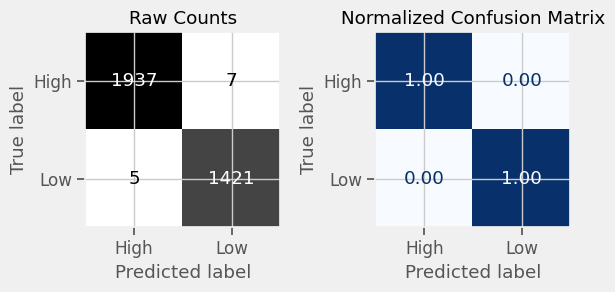


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.74      0.80      0.77       607
         Low       0.74      0.68      0.71       517

    accuracy                           0.74      1124
   macro avg       0.74      0.74      0.74      1124
weighted avg       0.74      0.74      0.74      1124



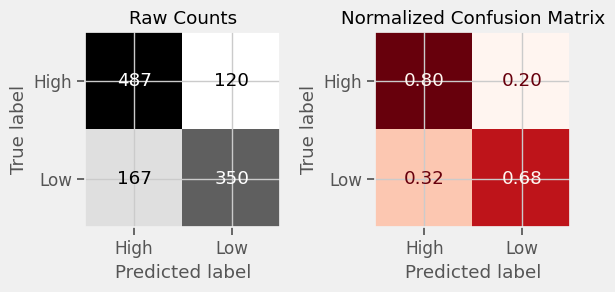

['Models/log-reg.joblib']

In [22]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.78      0.99      0.87      1944
         Low       0.98      0.62      0.76      1426

    accuracy                           0.83      3370
   macro avg       0.88      0.80      0.81      3370
weighted avg       0.86      0.83      0.82      3370



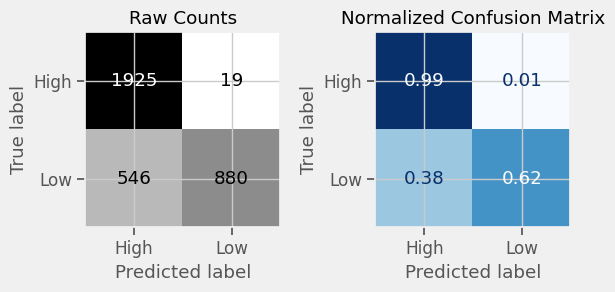


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.63      0.96      0.76       607
         Low       0.87      0.33      0.48       517

    accuracy                           0.67      1124
   macro avg       0.75      0.64      0.62      1124
weighted avg       0.74      0.67      0.63      1124



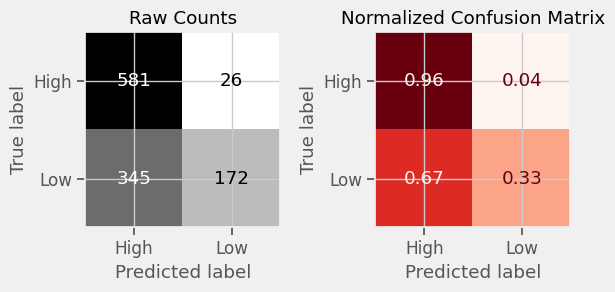

['Models/bayes-clf.joblib']

In [23]:
## Fit an evaluate a Naive Bayes Classifier
clf_bayes.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes'])

In [24]:
FPATHS['models']['ml']['random_forest']

'Models/random-forest.joblib'

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      1944
         Low       1.00      1.00      1.00      1426

    accuracy                           1.00      3370
   macro avg       1.00      1.00      1.00      3370
weighted avg       1.00      1.00      1.00      3370



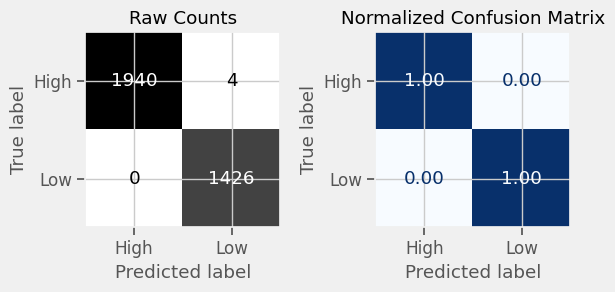


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.67      0.88      0.76       607
         Low       0.78      0.50      0.61       517

    accuracy                           0.71      1124
   macro avg       0.73      0.69      0.69      1124
weighted avg       0.72      0.71      0.69      1124



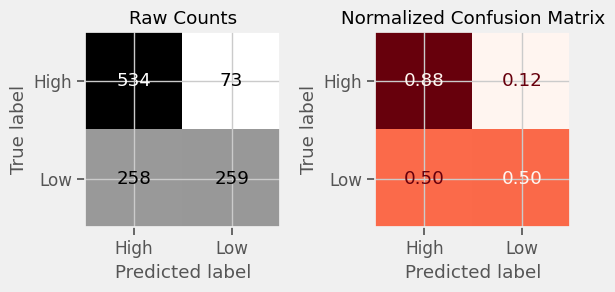

['Models/random-forest.joblib']

In [25]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier())
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

## GridSearching ML Models/Prep

In [26]:
# # Define params to try for both vectorizers
# # param_grid_clf = {'clf__C': [1e12,1e10]}

# param_grid_shared = {
#     "vectorizer__max_df": [0.7, 0.8, 0.9],
#     'vectorizer__min_df': [ 2, 3, 4 ], 
#     # "vectorizer__max_features": [None, 1000, 2000],
#     "vectorizer__stop_words": [None,'english']
# }

# # Setting params for the count vectorizer
# param_grid_count = {
#     'vectorizer':[CountVectorizer()],
#     **param_grid_shared
# }


# # Setting params for tfidf vectorizer 
# param_grid_tfidf = {
#     'vectorizer': [TfidfVectorizer()],
#     "vectorizer__norm": ["l1", "l2"],
#     "vectorizer__use_idf": [True, False],
#     **param_grid_shared
# }

# # combine into list of params
# params_combined = [param_grid_count, param_grid_tfidf]
# params_combined

In [27]:
# # logreg_pipe = Pipeline([
# #     ('vectorizer',TfidfVectorizer()),
# #     ('clf',LogisticRegression(max_iter=500))
# # ])

# logreg_pipe = Pipeline([
#     ('vectorizer',CountVectorizer()),
#     ('clf',MultinomialNB())
# ])


In [28]:
# %%time
# # Create grid search
# grid_search = GridSearchCV(logreg_pipe, params_combined, scoring='recall_macro',cv=3, verbose=1, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)


In [29]:
# grid_search.best_params_


In [30]:
# # Now define the best version of the model
# best_model = grid_search.best_estimator_

# # Predict and Evaluate with the custom function
# ds.evaluate_classification(best_model, X_train, y_train, X_test, y_test)


## GS from LP

In [31]:
# param_grid_shared = {
#     "vectorizer__max_df": [0.7, 0.8, 0.9],
#     'vectorizer__min_df': [ 2, 3, 4 ], 
#     # "vectorizer__max_features": [None, 1000, 2000],
#     "vectorizer__stop_words": [None,'english']
# }

# # Setting params for the count vectorizer
# param_grid_count = {
#     'vectorizer':[CountVectorizer()],
#     **param_grid_shared
# }


# # Setting params for tfidf vectorizer 
# param_grid_tfidf = {
#     'vectorizer': [TfidfVectorizer()],
#     "vectorizer__norm": ["l1", "l2"],
#     "vectorizer__use_idf": [True, False],
#     **param_grid_shared
# }


# # Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [5, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

# param_grid_MNB = {
#     'clf' : [MultinomialNB()],
#     'clf__alpha' : [.5, 1],
# }

# param_grid_logreg = {
#     'clf': [LogisticRegression(random_state = 42)],
#     'clf__C' : [.1, 1, 10, 100],
# }

# # combine into list of params
# model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]




In [32]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])



In [33]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]



In [34]:
# Define parameters to tune multiple models

# param_grid_RF = {
#     'clf' : [RandomForestClassifier(random_state = 42)],
#     'clf__max_depth' : [20, None],
#     'clf__min_samples_leaf' : [1, 2],
# }

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter=1000,random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [
    # param_grid_RF,
    param_grid_MNB, 
    param_grid_logreg]

In [35]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1]})

In [36]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [MultinomialNB()],
 'clf__alpha': [0.5, 1]}

In [37]:
# %%time
## TEMP: COMPARE TIMING IF n_jobs is NOT -1
# # Create grid search
# grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1)#, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [38]:
%%time
SKIP = False

if not SKIP:
    # Create grid search
    grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
        
        
    # Fit the model
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

{'clf': LogisticRegression(C=0.1, max_iter=1000, random_state=42), 'clf__C': 0.1, 'vectorizer': CountVectorizer(max_df=0.7, min_df=2, stop_words='english'), 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 2, 'vectorizer__stop_words': 'english'}
CPU times: user 23.4 s, sys: 16.8 s, total: 40.2 s
Wall time: 3min 36s


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.96      0.93      0.94      1944
         Low       0.91      0.95      0.93      1426

    accuracy                           0.94      3370
   macro avg       0.93      0.94      0.94      3370
weighted avg       0.94      0.94      0.94      3370



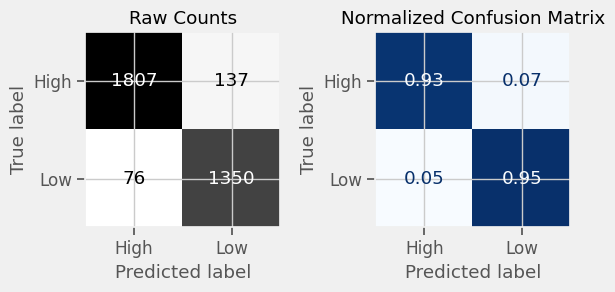


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.78      0.81      0.80       607
         Low       0.77      0.73      0.75       517

    accuracy                           0.77      1124
   macro avg       0.77      0.77      0.77      1124
weighted avg       0.77      0.77      0.77      1124



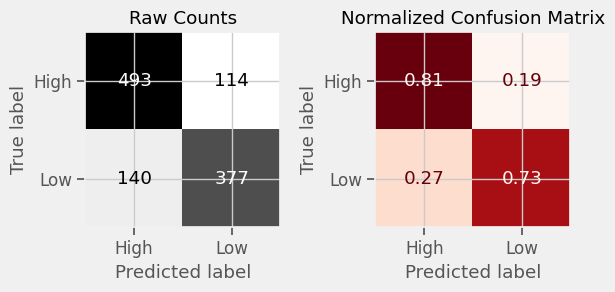

In [39]:
if not SKIP:
    
    # Now define the best version of the model
    best_model = grid_search.best_estimator_
    
    # Predict and Evaluate with the custom function
    ds.evaluate.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### Saving ML Model & Data

In [40]:

# Save training data
fpath_train_joblib = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train],fpath_train_joblib)

# Save test data
fpath_test_joblib = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test],fpath_test_joblib)

# if not SKIP:
#     # Saving the best model 
#     fpath_best_ml_model  = "Models/best-ml-model.joblib"
#     joblib.dump(best_model, fpath_best_ml_model)

['Data-NLP/testing-data.joblib']

## 👉11/30/23 Brenda 1:1 - Admin Test/Demo

### Ngrams

In [41]:
#our pre-exting ngram df function https://login.codingdojo.com/m/692/16501/124388

import pandas as pd
def get_ngram_measures_finder(tokens, ngrams=2, get_scores_df=False, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

### Text Explainer

In [42]:
X_to_pred = 'It was the best move i had ever seen until the last 30 mins, which ruined the whole thing.'

In [43]:
y

review_id
647165ef8813e400e2d7c6c2    High
60ea2d6e5e12000046005656    High
62dd7246ea84c7004fc691e5    High
535868070e0a26067f0007d2     Low
53f4879b0e0a267f8d001da8    High
                            ... 
5e12cdd7d64ac2001465016f     Low
5e12d1dc5907de0014dec438     Low
5e20d56f8f26bc001371c649     Low
5e20dedc397df000129666b8     Low
6449359c2fdec602fca107cb    High
Name: target-rating, Length: 4494, dtype: object

In [44]:
clf_bayes.predict([X_to_pred])

array(['Low'], dtype='<U4')

In [45]:
y.unique()

array(['High', 'Low'], dtype=object)

In [46]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=y.unique())
explanation = explainer.explain_instance(X_to_pred, clf_bayes.predict_proba)
explanation.show_in_notebook()

# Neural Networks

In [47]:
# raise

## ✅🚨 TO DO 11/30

- Write up tensorflow deployment lesson as I finalize model and dataset saving/loading 

In [97]:
def save_model(
    model=None,
    model_folder=None,
    overwrite=False,
    save_model_kws={},
    load_and_evaluate=True,
    train_ds=None,
    test_ds=None,
):
    ## allowing for JUST loading if no model and load_and_eval==True
    if (model == None) & (load_and_evaluate == None):
        raise Exception(
            "[!] Must either provide a model to save or sert load_and_evaluate to True to load only."
        )

    if model_folder == None:
        model_folder = "Models/model01/"

    # Create folder
    os.makedirs(model_folder, exist_ok=True)

    # Save Model. with keras.models.save_model
    try:
        tf.keras.models.save_model(model, model_folder, **save_model_kws)

    except Exception as e:
        print("[!] Save failed:")
        display(e)

    if load_and_evaluate == True:
        loaded = tf.keras.models.load_model(model_folder)
        display(
            ds.evaluate_classification_network(loaded, X_train=train_ds, X_test=test_ds)
        )  # , history=history);
        return loaded

In [98]:
from sklearn.preprocessing import LabelEncoder

In [99]:
# Define X and y
X = df_ml[text_col]
y_string= df_ml[target_col]

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y_string))
y.value_counts()

0    2551
1    1943
dtype: int64

In [100]:
# Convert to Dataset Object
full_ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
full_ds = full_ds.shuffle(buffer_size=len(full_ds), reshuffle_each_iteration=False,seed=321)

In [101]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(full_ds) * split_train)
n_val_samples = int(len(full_ds) * split_val)
n_test_samples = len(full_ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")



    - train:	3145 samples 	(99 batches)
    - val:  	898 samples 	(29 batches)
    - test: 	451 samples 	(15 batches)


In [102]:
# Use take and skip to define each set
train_ds = full_ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
train_ds = train_ds.shuffle(len(train_ds), seed=321)
# Skip over the training batches and take the validation batches
val_ds = full_ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = full_ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')



 There are 99 training batches.
 There are 29 validation batches.
 There are 15 testing batches.


In [103]:
# # taking a sample 
# example_X, example_y= train_ds.take(1).get_single_element()
# print(example_X)
# print(example_y)

In [104]:
## Saving Train and test dataset
fname_train_ds = FPATHS['data']['nn']['train']
train_ds.save(path=fname_train_ds,)

fname_test_ds = FPATHS['data']['nn']['test']
test_ds.save(path=fname_test_ds,)

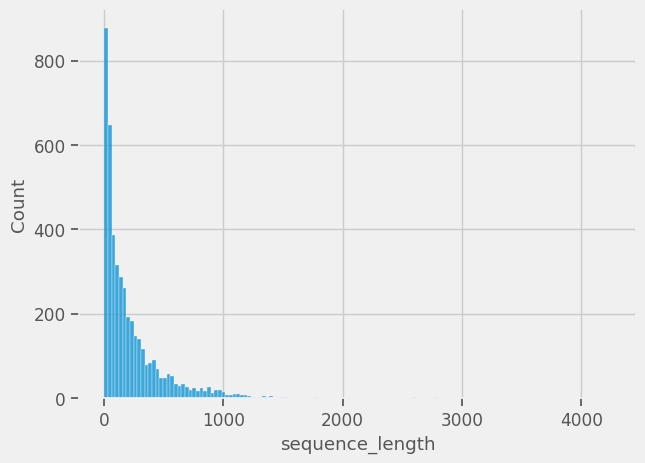

In [133]:
df_ml = df_ml.copy()
df_ml['sequence_length'] = df_ml['review_text'].map( lambda x: len(x.split(" ")))
ax = sns.histplot(df_ml['sequence_length'])

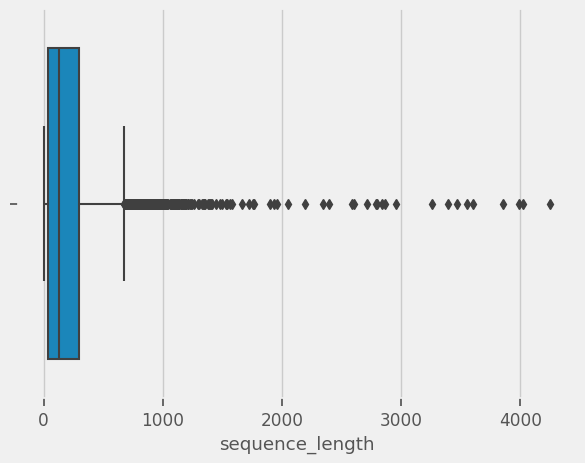

In [134]:
ax = sns.boxplot(data=df_ml, x='sequence_length')

In [135]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
# ds_texts.take(1).get_single_element()

In [136]:
SEQUENCE_LENGTH = 300
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)
sequence_vectorizer.adapt(ds_texts)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE


37417

In [137]:
# raise Exception("Update code below to use only what is shown on the LP")

#### LSTM

In [150]:
# Define a function for building an LSTM model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential

# @tf.function
def build_lstm_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )

    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(64,recurrent_dropout=.1, return_sequences=True))
    lstm_model.add(layers.Dropout(0.5))
    lstm_model.add(layers.LSTM(32))#, return_sequences=True)))
    # lstm_model.add(layers.GlobalMaxPooling1D())

    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation="softmax"))

    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    lstm_model.compile(
        optimizer=optimizer,  #'adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    lstm_model.summary()
    return lstm_model

In [151]:
# # Code below is from CNN Week
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, verbose=True)
#     return [early_stop]


### Call backs
# @tf.function
def get_callbacks(monitor='val_accuracy',patience=3, restore_best_weights=False,
                  start_from_epoch=0,baseline_value=None,
                  verbose_early_stopping=1,  
                  tensborboard=False, logdir="/tmp/tb_logs",
                 tb_embed_freq=0, tb_write_images = False, tb_hist_freq = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, #mode=mode, 
                                                      restore_best_weights=restore_best_weights,
                                                      baseline=baseline_value,
                                                      start_from_epoch=start_from_epoch,
                                                      verbose=verbose_early_stopping)

    if tensborboard:
        tboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=tb_hist_freq,write_images=tb_write_images,
                                                embeddings_freq=tb_embed_freq,)
        return [ early_stopping, tboard]
    else:
        return [early_stopping]

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_12 (Embedding)    (None, 300, 50)           1870850   
                                                                 
 lstm_18 (LSTM)              (None, 300, 64)           29440     
                                                                 
 dropout_6 (Dropout)         (None, 300, 64)           0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                     

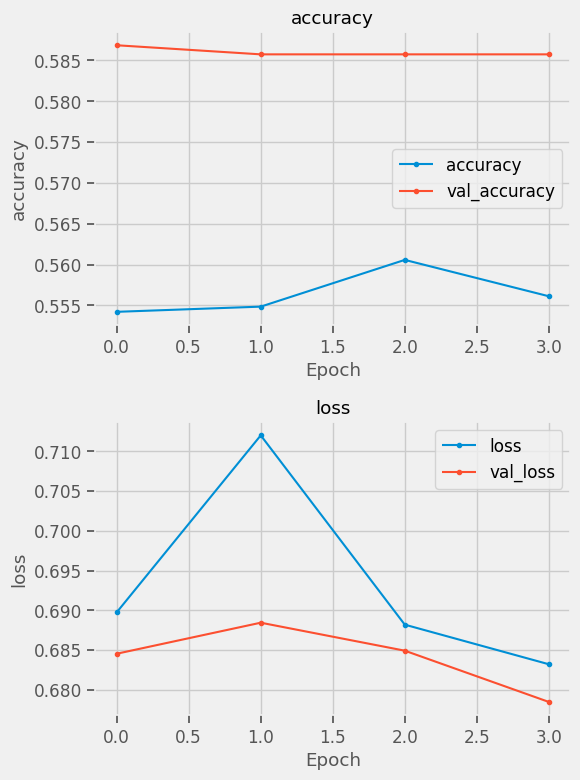

In [152]:
EMBED_DIM = 50
classes = y_train.unique()
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

ds.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1767
           1       0.00      0.00      0.00      1378

    accuracy                           0.56      3145
   macro avg       0.28      0.50      0.36      3145
weighted avg       0.32      0.56      0.40      3145



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

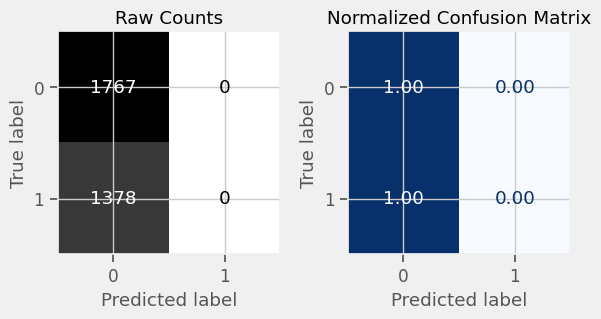


- Evaluating Training Data:
 3/99 [..............................] - ETA: 3s - loss: 0.6431 - accuracy: 0.5417

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

99/99 [==============================] - 3s 32ms/step - loss: 0.6589 - accuracy: 0.5618
{'loss': 0.6588718891143799, 'accuracy': 0.5618441700935364}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       258
           1       0.00      0.00      0.00       193

    accuracy                           0.57       451
   macro avg       0.29      0.50      0.36       451
weighted avg       0.33      0.57      0.42       451



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

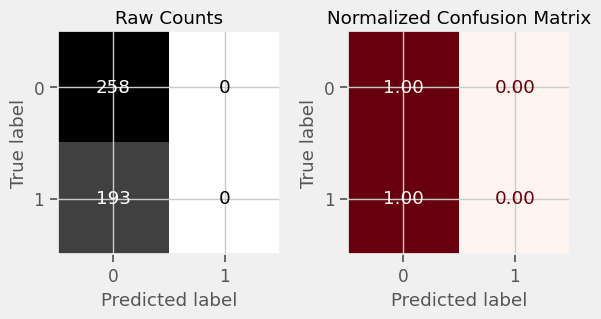


- Evaluating Test Data:
 3/15 [=====>........................] - ETA: 0s - loss: 0.6969 - accuracy: 0.5208

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

15/15 [==============================] - 0s 31ms/step - loss: 0.6799 - accuracy: 0.5721
{'loss': 0.6798805594444275, 'accuracy': 0.572062075138092}


In [153]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [154]:
# raise Exception("Add model fpaths to filepaths.json first and then use those below:")

#### Saving Model 1

In [155]:
# Saving model in tf format 
fname_model_lstm = FPATHS['models']['nn']['LSTM']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
lstm_model.save(fname_model_lstm, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/lstm/assets


INFO:tensorflow:Assets written to: Models/keras/lstm/assets


In [156]:
## Loading the Model
loaded_network = tf.keras.models.load_model(fname_model_lstm)
loaded_network.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_12 (Embedding)    (None, 300, 50)           1870850   
                                                                 
 lstm_18 (LSTM)              (None, 300, 64)           29440     
                                                                 
 dropout_6 (Dropout)         (None, 300, 64)           0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                     

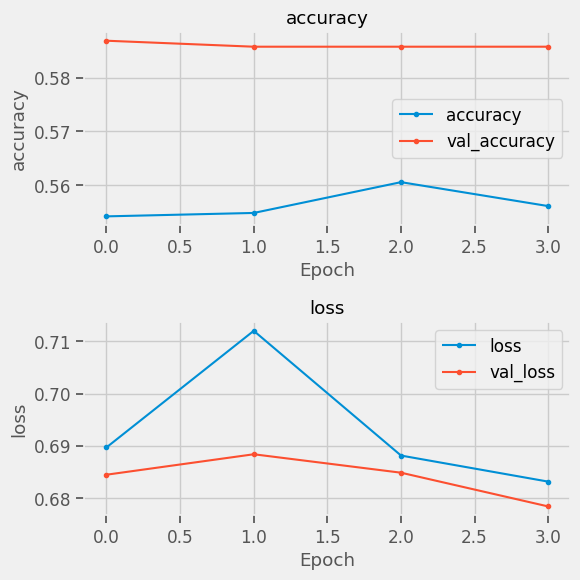


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1767
           1       0.00      0.00      0.00      1378

    accuracy                           0.56      3145
   macro avg       0.28      0.50      0.36      3145
weighted avg       0.32      0.56      0.40      3145



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

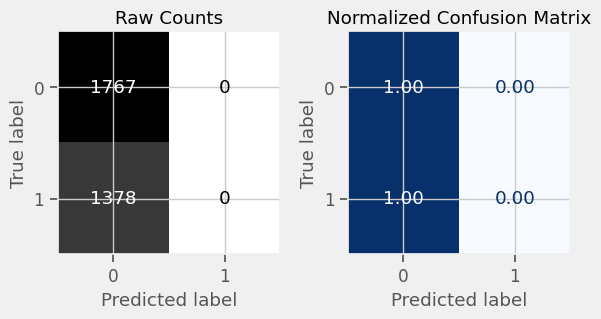

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


- Evaluating Training Data:
99/99 [==============================] - 4s 33ms/step - loss: 0.6589 - accuracy: 0.5618
{'loss': 0.6588720679283142, 'accuracy': 0.5618441700935364}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       258
           1       0.00      0.00      0.00       193

    accuracy                           0.57       451
   macro avg       0.29      0.50      0.36       451
weighted avg       0.33      0.57      0.42       451



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

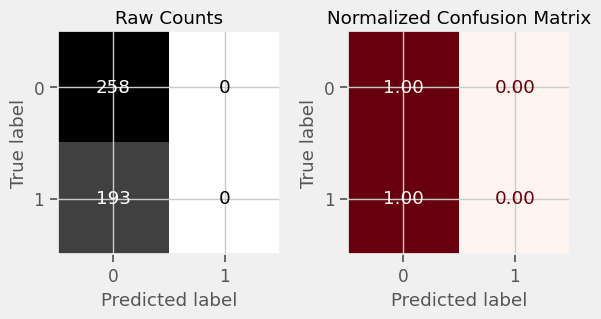


- Evaluating Test Data:
 3/15 [=====>........................] - ETA: 0s - loss: 0.6969 - accuracy: 0.5208

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

15/15 [==============================] - 0s 32ms/step - loss: 0.6799 - accuracy: 0.5721
{'loss': 0.6798805594444275, 'accuracy': 0.572062075138092}


In [157]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    loaded_network, X_train=train_ds, 
    X_test=test_ds, history=history
);

## Testing Saving/Loading Dataset Objects

### RNN Model 2

In [158]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=MAX_TOKENS,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_13 (Embedding)    (None, 300, 50)           1870850   
                                                                 
 bidirectional_17 (Bidirecti  (None, 300, 256)         138240    
 onal)                                                           
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                     

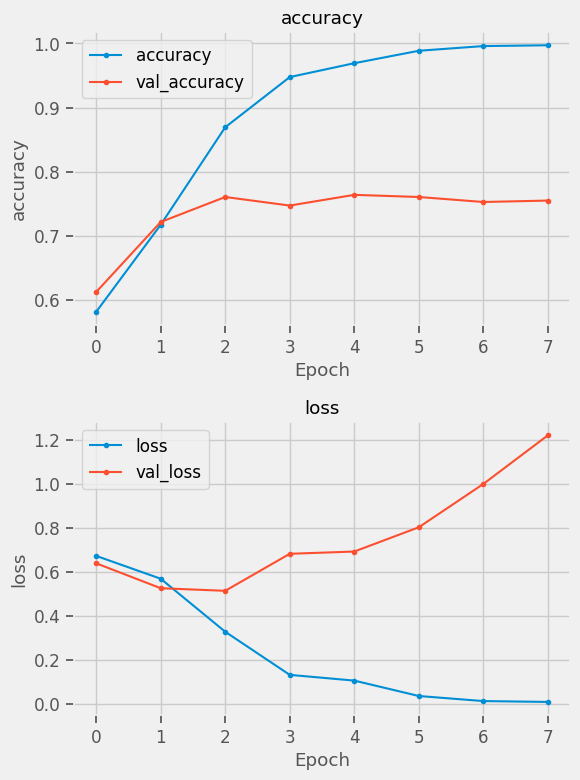

In [159]:
EMBED_DIM = 50
classes = y_train.unique()
MAX_TOKENS = sequence_vectorizer.vocabulary_size()
# Build the lstm model and specify the vectorizer
bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = bidirection_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
ds.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1767
           1       1.00      1.00      1.00      1378

    accuracy                           1.00      3145
   macro avg       1.00      1.00      1.00      3145
weighted avg       1.00      1.00      1.00      3145



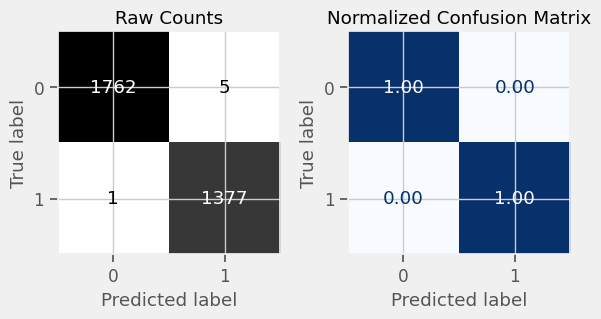


- Evaluating Training Data:
99/99 [==============================] - 4s 39ms/step - loss: 0.0063 - accuracy: 0.9981
{'loss': 0.006313316524028778, 'accuracy': 0.9980922341346741}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.75      0.74       258
           1       0.65      0.62      0.63       193

    accuracy                           0.69       451
   macro avg       0.69      0.68      0.69       451
weighted avg       0.69      0.69      0.69       451



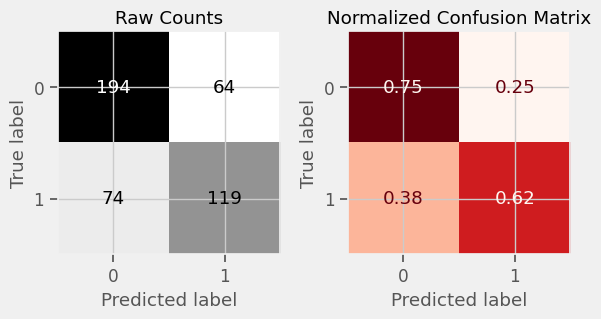


- Evaluating Test Data:
15/15 [==============================] - 1s 38ms/step - loss: 1.6331 - accuracy: 0.6940
{'loss': 1.633141040802002, 'accuracy': 0.6940132975578308}


In [160]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    bidirection_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [161]:
# Saving model in tf format 
fname_model_gru = FPATHS['models']['nn']['GRU']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
bidirection_model.save(fname_model_gru, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/gru/assets


INFO:tensorflow:Assets written to: Models/keras/gru/assets


### Saving Tensorflow Datasets and Best Model